In [ ]:
import torch
from glob import glob
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "data"  # Update the dataset path to point to the root folder
image_size = (224, 224)
num_classes = 4

# Define paths for train, validation, and test datasets
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

# Data augmentation for training, resizing for validation and testing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = glob(os.path.join(self.folder_path, '*', '*.jpg'))
        self.labels = [self.get_label(path) for path in self.image_paths]
        self.labels_to_index = {label: index for index, label in enumerate(list(set(self.labels)))}

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        label_index = self.labels_to_index[label]

        if self.transform:
            img = self.transform(img)

        return img, label_index

    def __len__(self):
        return len(self.image_paths)

    def get_label(self, path):
        # Get folder name as label (assumes directory name is the label)
        return os.path.basename(os.path.dirname(path))

# Load datasets
train_dataset = CustomDataset(train_dir, transform=train_transform)
val_dataset = CustomDataset(val_dir, transform=test_transform)
test_dataset = CustomDataset(test_dir, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check device and dataset sizes
print(device)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")


cuda
Training set size: 1370
Validation set size: 395
Testing set size: 191


c:\Users\0871\.conda\envs\gpu_torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\0871\.conda\envs\gpu_torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss: 0.4817, Train Acc: 83.87%, Val Loss: 0.3457, Val Acc: 86.84%
Epoch 2: Train Loss: 0.1718, Train Acc: 94.82%, Val Loss: 0.1943, Val Acc: 94.43%
Epoch 3: Train Loss: 0.1229, Train Acc: 96.28%, Val Loss: 0.1588, Val Acc: 95.44%
Epoch 4: Train Loss: 0.0865, Train Acc: 97.66%, Val Loss: 0.1548, Val Acc: 94.68%
Epoch 5: Train Loss: 0.0710, Train Acc: 97.88%, Val Loss: 0.2337, Val Acc: 91.39%
Epoch 6: Train Loss: 0.0546, Train Acc: 98.61%, Val Loss: 0.1325, Val Acc: 96.46%
Epoch 7: Train Loss: 0.0401, Train Acc: 98.61%, Val Loss: 0.2032, Val Acc: 94.94%
Epoch 8: Train Loss: 0.0404, Train Acc: 98.91%, Val Loss: 0.1171, Val Acc: 96.71%
Epoch 9: Train Loss: 0.0319, Train Acc: 99.20%, Val Loss: 0.1349, Val Acc: 95.95%
Epoch 10: Train Loss: 0.0218, Train Acc: 99.42%, Val Loss: 0.1711, Val Acc: 95.70%


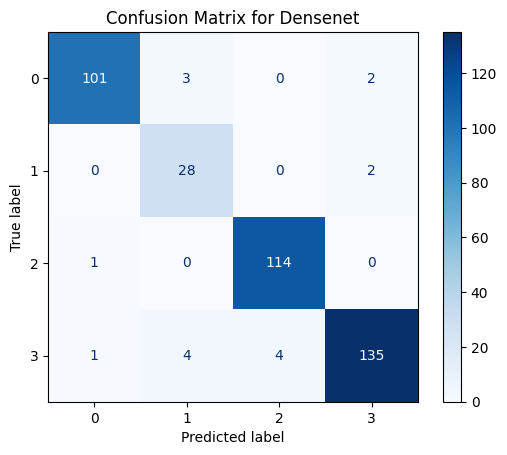

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       106
           1       0.80      0.93      0.86        30
           2       0.97      0.99      0.98       115
           3       0.97      0.94      0.95       144

    accuracy                           0.96       395
   macro avg       0.93      0.95      0.94       395
weighted avg       0.96      0.96      0.96       395



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Model definition
class DenseNetModel(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)  # Using DenseNet-121
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)  # Replace the classifier with a new one

    def forward(self, x):
        return self.densenet(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetModel(num_classes=4).to(device)  # Adjust num_classes accordingly
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "densenet.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Densenet")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))


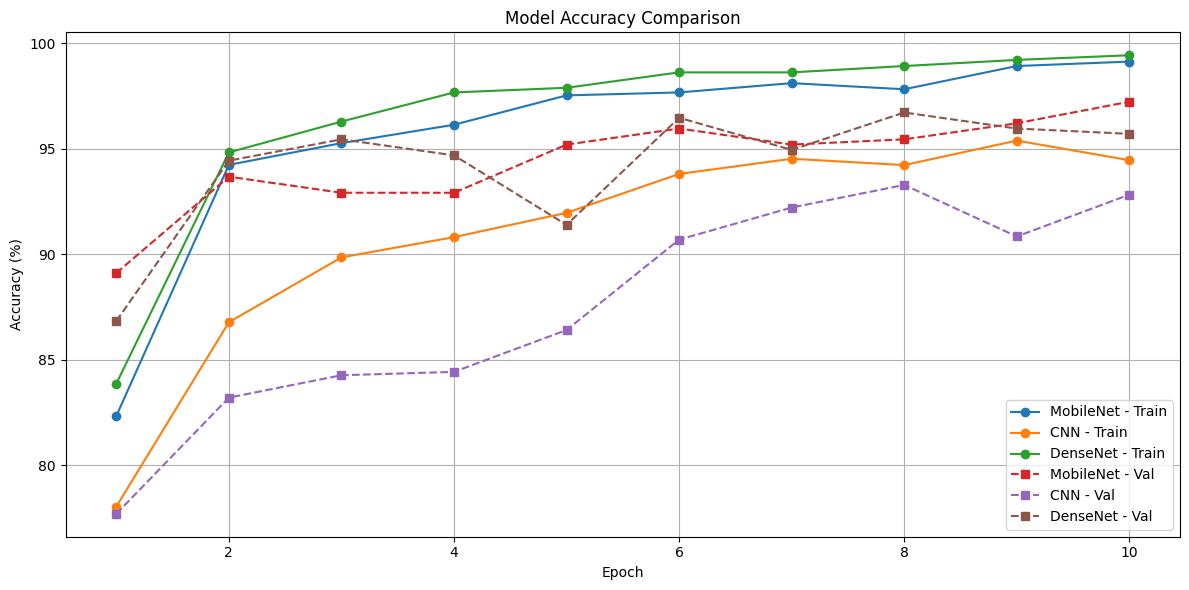

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create epoch list
epochs = list(range(1, 11))

# MobileNet
mobilenet_train_acc = [82.34, 94.23, 95.26, 96.13, 97.52, 97.66, 98.10, 97.81, 98.91, 99.12]
mobilenet_val_acc = [89.11, 93.67, 92.91, 92.91, 95.19, 95.95, 95.19, 95.44, 96.20, 97.22]

# CNN
cnn_train_acc = [78.05, 86.78, 89.85, 90.81, 91.96, 93.80, 94.52, 94.22, 95.38, 94.45]
cnn_val_acc = [77.71, 83.21, 84.27, 84.43, 86.41, 90.69, 92.21, 93.28, 90.84, 92.82]

# DenseNet
densenet_train_acc = [83.87, 94.82, 96.28, 97.66, 97.88, 98.61, 98.61, 98.91, 99.20, 99.42]
densenet_val_acc = [86.84, 94.43, 95.44, 94.68, 91.39, 96.46, 94.94, 96.71, 95.95, 95.70]

# Plotting
plt.figure(figsize=(12, 6))

# Train Accuracy
plt.plot(epochs, mobilenet_train_acc, marker='o', label='MobileNet - Train')
plt.plot(epochs, cnn_train_acc, marker='o', label='CNN - Train')
plt.plot(epochs, densenet_train_acc, marker='o', label='DenseNet - Train')

# Val Accuracy
plt.plot(epochs, mobilenet_val_acc, marker='s', linestyle='--', label='MobileNet - Val')
plt.plot(epochs, cnn_val_acc, marker='s', linestyle='--', label='CNN - Val')
plt.plot(epochs, densenet_val_acc, marker='s', linestyle='--', label='DenseNet - Val')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


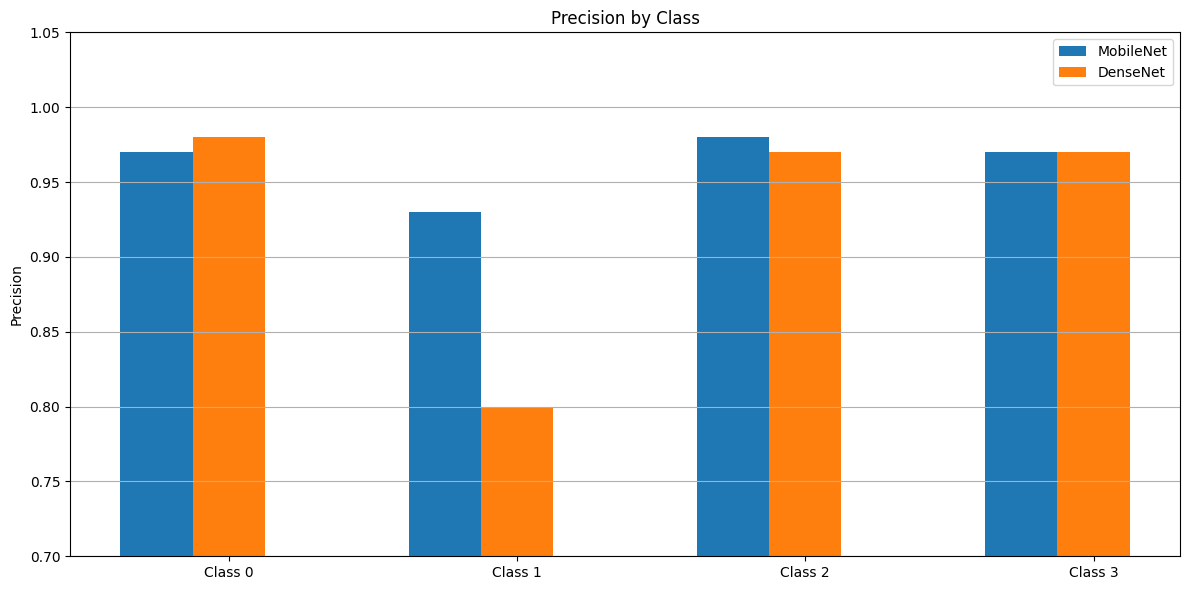

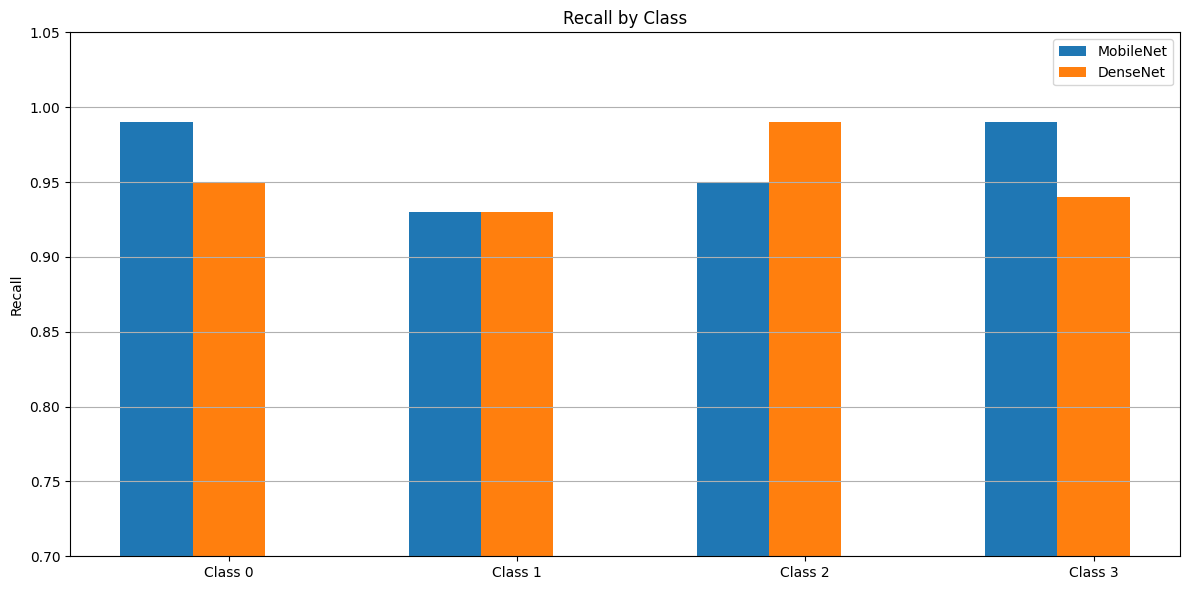

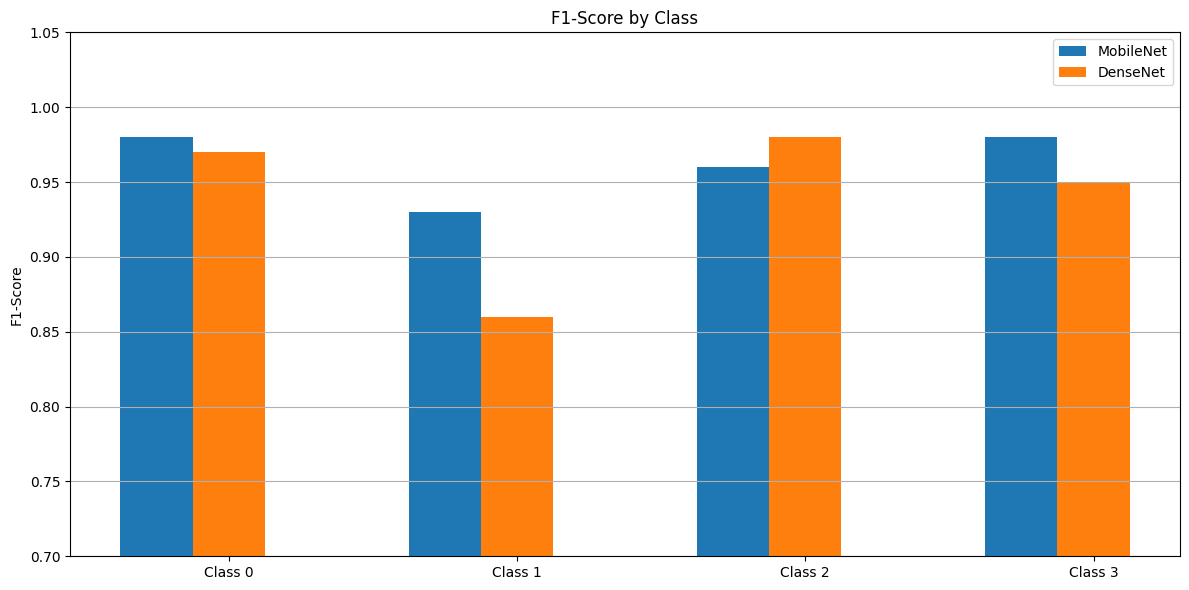

In [ ]:
import numpy as np

# Classification report values
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# MobileNet
mobilenet_precision = [0.97, 0.93, 0.98, 0.97]
mobilenet_recall = [0.99, 0.93, 0.95, 0.99]
mobilenet_f1 = [0.98, 0.93, 0.96, 0.98]

# CNN classification report not provided, skipping it for now.

# DenseNet
densenet_precision = [0.98, 0.80, 0.97, 0.97]
densenet_recall = [0.95, 0.93, 0.99, 0.94]
densenet_f1 = [0.97, 0.86, 0.98, 0.95]

x = np.arange(len(labels))  # label locations
width = 0.25  # width of bars

# Plotting Precision
plt.figure(figsize=(12, 6))
plt.bar(x - width, mobilenet_precision, width, label='MobileNet')
plt.bar(x, densenet_precision, width, label='DenseNet')
plt.ylabel('Precision')
plt.title('Precision by Class')
plt.xticks(x, labels)
plt.ylim(0.7, 1.05)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plotting Recall
plt.figure(figsize=(12, 6))
plt.bar(x - width, mobilenet_recall, width, label='MobileNet')
plt.bar(x, densenet_recall, width, label='DenseNet')
plt.ylabel('Recall')
plt.title('Recall by Class')
plt.xticks(x, labels)
plt.ylim(0.7, 1.05)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plotting F1-Score
plt.figure(figsize=(12, 6))
plt.bar(x - width, mobilenet_f1, width, label='MobileNet')
plt.bar(x, densenet_f1, width, label='DenseNet')
plt.ylabel('F1-Score')
plt.title('F1-Score by Class')
plt.xticks(x, labels)
plt.ylim(0.7, 1.05)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
